In [1]:
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
import os
from os.path import join as pj
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
result_root = pj(os.getcwd(), "result/master_paper/resource_estimation")
df_root_path = pj(os.getcwd(), "figure/det2cls/master_paper/refinedet_plus_other_resnet_size")

### mean AP, Precision, Recall

In [3]:
target_df = pd.read_csv(pj(df_root_path, "target_df.csv"))
target_df = target_df.drop("Unnamed: 0", axis=1)
target_df.index = ["Other", "Aquatic Insect"]
target_df

,AP,Precision,Recall
Other,0.689822,0.230440,0.928097
Aquatic Insect,0.813586,0.345655,0.917618


### AP, Precision, Recall

In [4]:
insect_names = ['Diptera', 'Ephemeridae', 'Ephemeroptera', 'Lepidoptera', 'Plecoptera', 'Trichoptera']

In [5]:
target_df = pd.read_csv(pj(df_root_path, "each_target_df.csv"))
target_df = target_df.drop("Unnamed: 0", axis=1)
target_df.index = insect_names
target_df

,AP,Precision,Recall
Diptera,0.713476,0.225040,0.843564
Ephemeridae,0.863981,0.258303,0.979021
Ephemeroptera,0.719180,0.346101,0.863481
Lepidoptera,0.925067,0.489272,0.957202
Plecoptera,0.842713,0.395290,0.953347
Trichoptera,0.817101,0.359922,0.909091


### Compare Size Distribution

In [6]:
cls_and_size_df = pd.read_csv(pj(df_root_path, "cls_and_size_df.csv"))
cls_and_size_df = cls_and_size_df.drop("Unnamed: 0", axis=1)
cls_and_size_df_gt = pd.read_csv(pj(df_root_path, "cls_and_size_df_gt.csv"))
cls_and_size_df_gt = cls_and_size_df_gt.drop("Unnamed: 0", axis=1)

In [7]:
lbl_to_name = {
    0: 'Diptera', 
    1: 'Ephemeridae', 
    2: 'Ephemeroptera', 
    3: 'Lepidoptera', 
    4: 'Plecoptera', 
    5: 'Trichoptera', 
}

In [8]:
def get_insect_size_dic(Y, sizes, lbl_to_name):
    """
        get dictionary of label to size
        Args:
            - Y: np.array(dtype=int), shape==[insect_num]
            - sizes: np.array(dtype=float), shape==[insect_num]
            - lbl_to_name: dict, {label: label_name}
    """
    insect_size_dic = {}
    for i in range(len(lbl_to_name)):
        insect_filter = Y == i
        filtered_X_size = sizes[insect_filter]
        filtered_X_size = np.sort(filtered_X_size)
        insect_size_dic.update({lbl_to_name[i]: filtered_X_size})
    return insect_size_dic

def gaussian(mu, sigma):
    """
        return gaussian distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    def f(x):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma) / np.sqrt(2 * np.pi * sigma)
    return f

def laplace(mu, sigma):
    """
        return laplace distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    b = np.sqrt(sigma / 2)
    def f(x):
        return 1 / (2 * b) * np.exp(-1 * np.abs(x - mu) / b)
    return f

def calc_mu_sigma(insect_size_dic):
    """
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu = []
    sigma = []
    for key, value in insect_size_dic.items():
        x = np.log2(insect_size_dic[key])
        gmm.fit(x.reshape(-1, 1))
        mu.append(gmm.means_.reshape([-1])[0])
        sigma.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu), np.array(sigma)

def plot_hist_and_distribution(x, seq, mu, sigma, label_name, x_uniform=None, mu_uniform=None, sigma_uniform=None):
    """
        plot histgram and gaussian distribution
        Args:
            - x: np.array(dtype=float)
            - seq: np.array(dtype=float)
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - label_name: str
            - x_uniform: np.array(dtype=float)
            - mu_uniform: np.array(dtype=float), shape == [class_num]
            - sigma_uniform: np.array(dtype=float), shape == [class_num]
    """
    if x_uniform is not None and mu_uniform is not None and sigma_uniform is not None:
        fig, axe = plt.subplots(1, 2, figsize=(10, 5))
        axe[0].hist(x, bins=100, density=True)
        axe[0].plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        axe[0].set_title(label_name + " (Ground Truth)", fontsize=14)
        axe[0].set_xlabel("Insect size exponent of base 2", fontsize=14)
        axe[0].set_ylabel("Probability density", fontsize=14)
        axe[1].hist(x_uniform, bins=100, density=True)
        axe[1].plot(seq, gaussian(mu_uniform, sigma_uniform)(seq), linewidth=2, color="red")
        axe[1].set_title(label_name + " (Model Output)", fontsize=14)
        axe[1].set_xlabel("Insect size exponent of base 2", fontsize=14)
        axe[1].set_ylabel("Probability density", fontsize=14)
        plt.tight_layout()
        plt.savefig(pj(result_root, label_name + "_size_distribution.png"))
    else:
        plt.hist(x, bins=100, density=True)
        plt.plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        plt.title(label_name, fontsize=14)

In [9]:
insect_size_dic = get_insect_size_dic(np.array(cls_and_size_df["lbl"]), np.array(cls_and_size_df["size"]), lbl_to_name)
mu, sigma = calc_mu_sigma(insect_size_dic)
insect_size_dic_gt = get_insect_size_dic(np.array(cls_and_size_df_gt["lbl"]), np.array(cls_and_size_df_gt["size"]), lbl_to_name)
mu_gt, sigma_gt = calc_mu_sigma(insect_size_dic_gt)
gauss_df = pd.DataFrame({"mu": mu, "mu_gt": mu_gt, "sigma": sigma, "sigma_gt": sigma_gt})
gauss_df.index = ["Diptera", "Ephemeridae", "Ephemeroptera", "Lepidoptera", "Plecoptera", "Trichoptera"]

In [10]:
gauss_df

,mu,mu_gt,sigma,sigma_gt
Diptera,4.540910,4.388058,0.680625,0.767773
Ephemeridae,6.332090,6.390962,0.442355,0.294352
Ephemeroptera,5.013528,5.119300,0.608381,0.675633
Lepidoptera,5.804101,5.833527,0.575374,0.579016
Plecoptera,5.528924,5.460814,0.488381,0.420820
Trichoptera,5.522521,5.585883,0.446350,0.463656


### mean Evaluation of Size Estimation

### --- Ground Truth ---

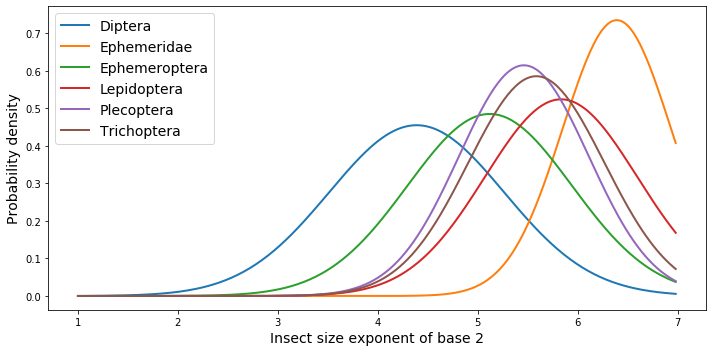

In [11]:
plt.figure(figsize=(10,5))
seq = np.arange(1.0, 7.0, 0.02)
plt.plot(seq, gaussian(mu_gt[0], sigma_gt[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_gt[1], sigma_gt[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_gt[2], sigma_gt[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_gt[3], sigma_gt[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_gt[4], sigma_gt[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_gt[5], sigma_gt[5])(seq), linewidth=2, label="Trichoptera")
plt.xlabel("Insect size exponent of base 2", fontsize=14)
plt.ylabel("Probability density", fontsize=14)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig(pj(result_root, "size_distribution_gt.png"))

### --- Model output ---

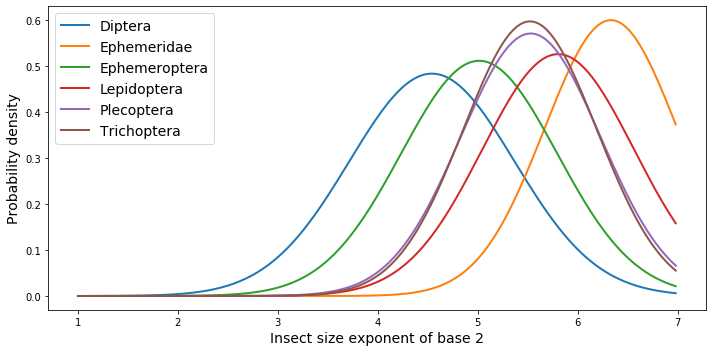

In [12]:
plt.figure(figsize=(10,5))
seq = np.arange(1.0, 7.0, 0.02)
plt.plot(seq, gaussian(mu[0], sigma[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu[1], sigma[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu[2], sigma[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu[3], sigma[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu[4], sigma[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu[5], sigma[5])(seq), linewidth=2, label="Trichoptera")
plt.xlabel("Insect size exponent of base 2", fontsize=14)
plt.ylabel("Probability density", fontsize=14)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig(pj(result_root, "size_distribution.png"))

### Evaluation of Size Estimation per label

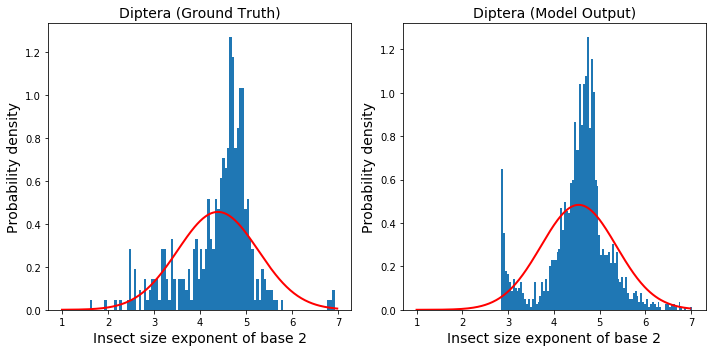

In [13]:
x = np.log2(insect_size_dic["Diptera"])
x_gt = np.log2(insect_size_dic_gt["Diptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[0], sigma_gt[0], "Diptera", x, mu[0], sigma[0])

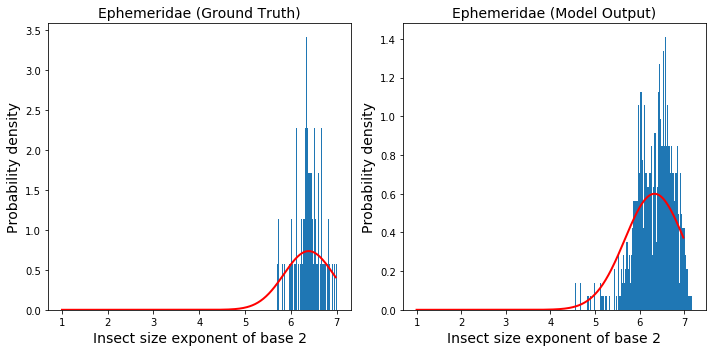

In [14]:
x = np.log2(insect_size_dic["Ephemeridae"])
x_gt = np.log2(insect_size_dic_gt["Ephemeridae"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[1], sigma_gt[1], "Ephemeridae", x, mu[1], sigma[1])

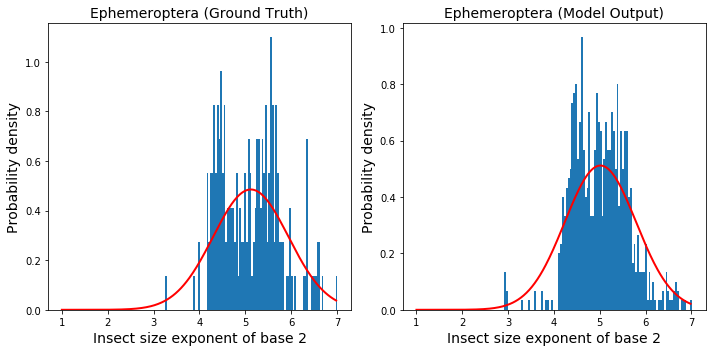

In [15]:
x = np.log2(insect_size_dic["Ephemeroptera"])
x_gt = np.log2(insect_size_dic_gt["Ephemeroptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[2], sigma_gt[2], "Ephemeroptera", x, mu[2], sigma[2])

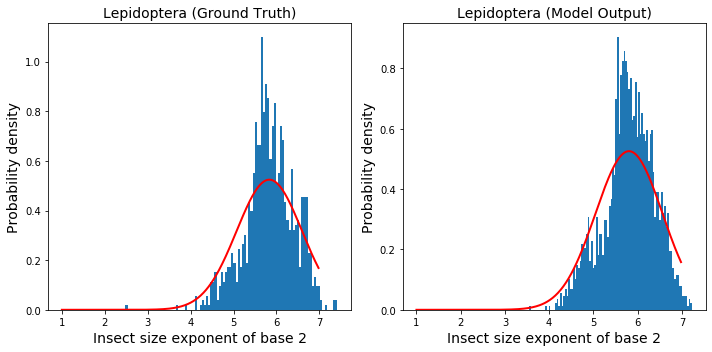

In [16]:
x = np.log2(insect_size_dic["Lepidoptera"])
x_gt = np.log2(insect_size_dic_gt["Lepidoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[3], sigma_gt[3], "Lepidoptera", x, mu[3], sigma[3])

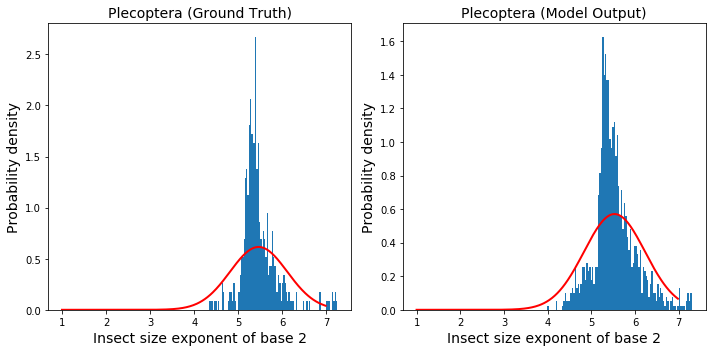

In [17]:
x = np.log2(insect_size_dic["Plecoptera"])
x_gt = np.log2(insect_size_dic_gt["Plecoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[4], sigma_gt[4], "Plecoptera", x, mu[4], sigma[4])

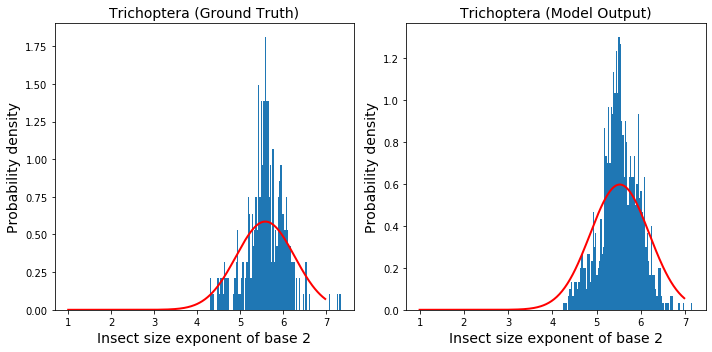

In [18]:
x = np.log2(insect_size_dic["Trichoptera"])
x_gt = np.log2(insect_size_dic_gt["Trichoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x_gt, seq, mu_gt[5], sigma_gt[5], "Trichoptera", x, mu[5], sigma[5])